## COMP3340 Group 9 - PPO - LSTM

In [1]:
NO_TRAINING = True
# NO_TRAINING = False

In [2]:
import numpy as np

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure

import torch

np.random.seed(0)
torch.manual_seed(0)

CONFIG_PATH = "LunarLander-v2-PPO-LSTM/"

In [3]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), CONFIG_PATH))

In [4]:
from policy_config import exp_config

cfg = {
    'gamma': exp_config['discount_factor'],
    'gae_lambda': exp_config['gae_lambda'],
    'n_epochs': exp_config['epoch_per_collect'],
    'batch_size': exp_config['batch_size'],
    'learning_rate': exp_config['learning_rate'],
    'vf_coef': exp_config['value_weight'],
    'ent_coef': exp_config['entropy_weight'],
    'clip_range': exp_config['clip_ratio'],
    'normalize_advantage': exp_config['adv_norm'],
    'max_grad_norm': exp_config['grad_norm'],
    'n_steps': exp_config['n_sample'],
}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHKPT_PATH = f"{CONFIG_PATH}/ckpt/manual_final"
LOG_FILE_PATH = f"{CONFIG_PATH}/log/train"

if NO_TRAINING:
    model = RecurrentPPO.load(CHKPT_PATH, device=device)
else:
    logger = configure(LOG_FILE_PATH, ["csv", "log"])
    model = RecurrentPPO(
        "MlpLstmPolicy", 
        "LunarLander-v2", 
        device=device,
        **cfg
    )
    model.set_logger(logger)
    model.learn(2_000_000)
    model.save(CHKPT_PATH)

In [6]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

env = gym.make("LunarLander-v2", render_mode="rgb_array")
vec_env = DummyVecEnv([lambda:env])
vec_env.seed(0)

mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=20, warn=False)
print(mean_reward)

c:\Users\User\.conda\envs\ppo\lib\site-packages\Box2D\Box2D.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


211.54302769957545


In [7]:
import cv2

obs = vec_env.reset()
# cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
# Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)

while True:
    action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    episode_starts = dones
    vec_env.render("human")
    
    if dones.item():
        cv2.destroyAllWindows()
        break

## Visualization

<Axes: xlabel='step'>

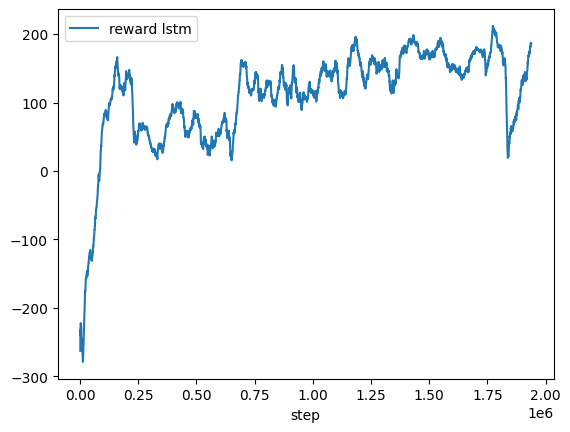

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

progress_lstm = pd.read_csv(f"{LOG_FILE_PATH}/progress.csv")
progress_lstm = progress_lstm.rename(columns={
    "time/total_timesteps": "step",
    "rollout/ep_rew_mean": "reward lstm"
})
progress_lstm.plot(x="step", y="reward lstm")

### Compare with MLP-only PPO

<Axes: title={'center': 'PPO MLP vs LSTM'}, xlabel='step'>

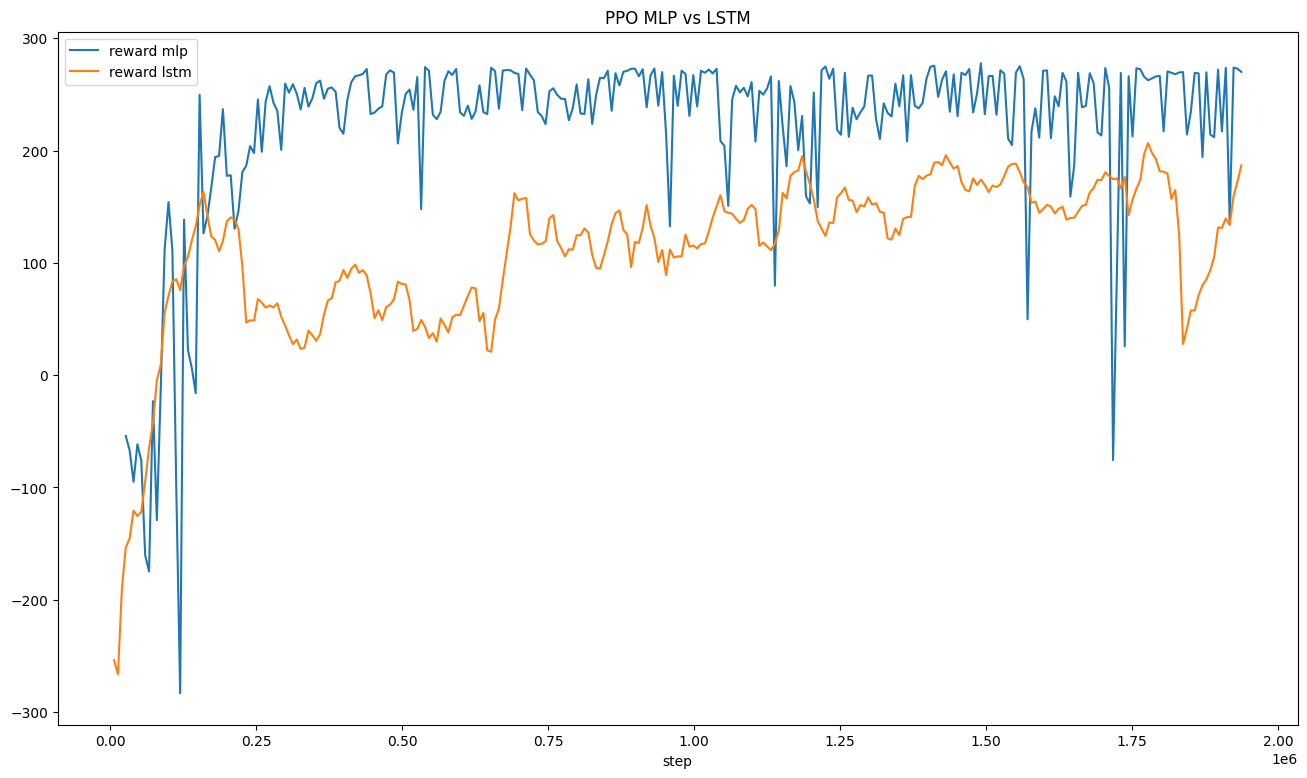

In [9]:
progress_mlp = pd.read_csv(f"{LOG_FILE_PATH.replace('LSTM', 'MLP')}/training.csv")
progress_mlp = progress_mlp[progress_mlp["step"] <= 2e6][progress_mlp > -300]
progress_mlp = progress_mlp.rename(columns={ "reward": "reward mlp" })

merged = pd.merge(progress_mlp[["step", "reward mlp"]], progress_lstm[["step", "reward lstm"]], how="inner", on="step")
merged.plot(x="step", title="PPO MLP vs LSTM", figsize=(16,9))